In [2]:
import random

from typing import TypedDict
from langgraph.graph import StateGraph, END

In [3]:
class AgentState(TypedDict):
    """State for the agent."""
    name: str
    number: list[int]
    counter: int

In [5]:
def greeting_node(state: AgentState) -> AgentState:
    """Generate a greeting message."""
    state["name"] = f"Hi there, {state['name']}!"
    state["counter"] = 0
    return state

def random_node(state: AgentState) -> AgentState:
    """Generate a random number and add it to the state."""
    state["number"].append(random.randint(1, 100))
    state["counter"] += 1
    return state

def should_continue(state: AgentState) -> AgentState:
    """Check if the agent should continue."""
    if state["counter"] < 5:
        print(f"ENTERING LOOP: {state['counter']}")
        return "loop" # Continue the loop
    else:
        print(f"EXITING LOOP: {state['counter']}")
        return "exit" # Exit the loop

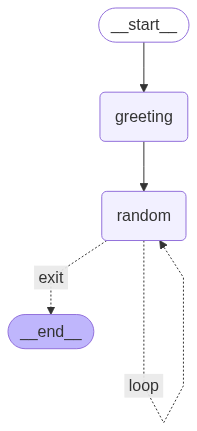

In [ ]:
graph = StateGraph(state_schema=AgentState)

graph.add_node(node="greeting", action=greeting_node)
graph.add_node(node="random", action=random_node)

graph.set_entry_point(key="greeting")
graph.add_edge(start_key="greeting", end_key="random")
graph.add_conditional_edges(
    source="random",
    path=should_continue,
    path_map={"loop": "random", "exit": END}
)
app = graph.compile()
app

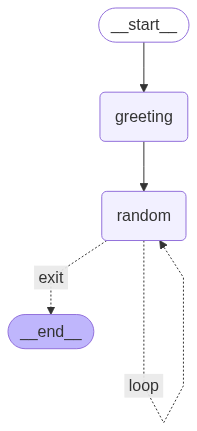

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
app.invoke({"name": "Alice", "number": [], "counter": -103})

ENTERING LOOP: 1
ENTERING LOOP: 2
ENTERING LOOP: 3
ENTERING LOOP: 4
EXITING LOOP: 5


{'name': 'Hi there, Alice!', 'number': [82, 23, 69, 5, 53], 'counter': 5}

In [28]:
class AgentState(TypedDict):
    """State for the agent."""
    player_name: str
    target_number: int
    guesses: list[int]
    attempts: int
    hint: str
    lower_bound: int
    upper_bound: int

In [33]:
def setup_node(state: AgentState) -> AgentState:
    """Setup the agent state."""
    state["player_name"] = f"Hi there, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game on! Try to guess the number between 1 and 20."
    state["lower_bound"] = 1
    state["upper_bound"] = 20
    print(f"Player {state['player_name']} is trying to guess the number {state['target_number']}.")
    return state

def guess_node(state: AgentState) -> AgentState:
    """Process the player's guess."""
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        guess = random.randint(state["lower_bound"], state["upper_bound"])

    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Player {state['player_name']} guessed: {guess}")
    return state

def hint_node(state: AgentState) -> AgentState:
    """Provide a hint based on the player's guess."""
    if state["guesses"][-1] < state["target_number"]:
        state["hint"] = "Higher!"
        state["lower_bound"] = max(state["lower_bound"], state["guesses"][-1] + 1)
    elif state["guesses"][-1] > state["target_number"]:
        state["hint"] = "Lower!"
        state["upper_bound"] = min(state["upper_bound"], state["guesses"][-1] - 1)
    else:
        state["hint"] = f"Correct! The number was {state['target_number']} and you guessed in {state['attempts']}."
    print(f"Hint: {state['hint']}")
    return state

In [ ]:
def hint_node(state: AgentState) -> AgentState:
    """Provide a hint based on the player's guess."""
    match state["guesses"][-1]:
        case guess if guess < state["target_number"]:
            state["hint"] = "Higher!"
            state["lower_bound"] = max(state["lower_bound"], guess + 1)
        case guess if guess > state["target_number"]:
            state["hint"] = "Lower!"
            state["upper_bound"] = min(state["upper_bound"], guess - 1)
        case _:
            state["hint"] = f"Correct! The number was {state['target_number']} and you guessed in {state['attempts']}."
    print(f"Hint: {state['hint']}")
    return state

In [34]:
def should_continue(state: AgentState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

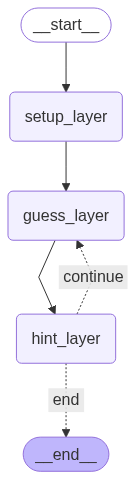

In [ ]:
graph = StateGraph(state_schema=AgentState)

graph.add_node(node="setup_layer", action=setup_node)
graph.add_node(node="guess_layer", action=guess_node)
graph.add_node(node="hint_layer", action=hint_node)

graph.set_entry_point(key="setup_layer")

graph.add_edge(start_key="setup_layer", end_key="guess_layer")

graph.add_conditional_edges(
    source="hint_layer",
    path=should_continue,
    path_map={"continue": "guess_layer", "end": END}
)

graph.add_edge(start_key="guess_layer", end_key="hint_layer")

app = graph.compile()
app

In [42]:
result = app.invoke({"player_name": "Student", "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20})

Player Hi there, Student! is trying to guess the number 5.
Player Hi there, Student! guessed: 11
Hint: Lower!
CONTINUING: 1/7 attempts used
Player Hi there, Student! guessed: 9
Hint: Lower!
CONTINUING: 2/7 attempts used
Player Hi there, Student! guessed: 3
Hint: Higher!
CONTINUING: 3/7 attempts used
Player Hi there, Student! guessed: 7
Hint: Lower!
CONTINUING: 4/7 attempts used
Player Hi there, Student! guessed: 4
Hint: Higher!
CONTINUING: 5/7 attempts used
Player Hi there, Student! guessed: 6
Hint: Lower!
CONTINUING: 6/7 attempts used
Player Hi there, Student! guessed: 5
Hint: Correct! The number was 5 and you guessed in 7.
GAME OVER: Number found!
